## imports

In [163]:
import requests
import pandas as pd
import numpy as np
import mysql.connector
import os
import importlib

import data.daily
import sqlalchemy
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from pandas_market_calendars import get_calendar

In [2]:
import urllib.parse as urlparse
from urllib.parse import urlencode

In [3]:
polygon_api_key = os.getenv("QUANT_GALORE_POLYGON_API_KEY")
_POLYGON_V2_BASE_URL = "https://api.polygon.io/v2"
_POLYGON_V3_BASE_URL = "https://api.polygon.io/v3"

In [4]:
calendar = get_calendar("NYSE")
trading_dates = calendar.schedule(
    start_date = "2023-05-01", 
    end_date = "2024-07-02"
    #end_date = (datetime.today()-timedelta(days = 1))
).index.strftime("%Y-%m-%d").values

In [6]:
ticker_spy = "SPY"
ticker_spx = "I:SPX"
ticker_goog = "GOOG"
ticker_sbux = "SBUX"
ticker_vix1d = "I:VIX1D"
options_ticker = "SPX"

i = 2
date = trading_dates[i]
prior_day = trading_dates[i-1]

trade_list = []
times = []

In [156]:
df_spy_daily_history = pd.read_pickle('market_data/df_spy_daily_history.pkl')
df_spx_daily_history = pd.read_pickle('market_data/df_spx_daily_history.pkl')
df_goog_daily_history = pd.read_pickle('market_data/df_goog_daily_history.pkl')
df_sbux_daily_history = pd.read_pickle('market_data/df_sbux_daily_history.pkl')

df_spy_intraday_history = pd.read_pickle('market_data/df_spy_intraday_history.pkl')
df_vix1d_intraday_history = pd.read_pickle('market_data/df_vix1d_intraday_history.pkl')
df_spx_intraday_history = pd.read_pickle('market_data/df_spx_intraday_history.pkl')
df_goog_intraday_history = pd.read_pickle('market_data/df_goog_intraday_history.pkl')
df_sbux_intraday_history = pd.read_pickle('market_data/df_sbux_intraday_history.pkl')

df_spx_call_options_history = pd.read_pickle('market_data/df_spx_call_options_history.pkl')
df_spx_put_options_history = pd.read_pickle('market_data/df_spx_put_options_history.pkl')

## cache history intraday data

In [16]:
def get_df_intrady_history(ticker):
    dfs = []
    for date in trading_dates[1:]:
        df_intraday = polygon_result_to_dataframe(get_polygon_result_dict(
            get_polygon_intraday_query_url(ticker, date)))
        dfs.append(df_intraday.reset_index())
    df = pd.concat(dfs, ignore_index=True).set_index("t")
    return df

In [157]:
df_spx_daily_history = pd.read_pickle('market_data/df_spx_daily_history.pkl')

## logic

In [35]:
df_spy = df_spy_daily_history[["c"]].copy()

In [36]:
df_spy["1_mo_avg"] = df_spy["c"].rolling(window=20).mean()
df_spy["3_mo_avg"] = df_spy["c"].rolling(window=60).mean()
df_spy['regime'] = df_spy.apply(lambda row: 1 if (row['c'] > row['1_mo_avg']) else -1, axis=1)

In [159]:
df_spy_market_open_history = data.daily.get_df_market_open_or_close_history_from_intraday_history(df_spy_intraday_history, "open")
df_vix1d_market_open_history = data.daily.get_df_market_open_or_close_history_from_intraday_history(df_vix1d_intraday_history, "open")
df_spx_market_open_history = data.daily.get_df_market_open_or_close_history_from_intraday_history(df_spx_intraday_history, "open")

In [40]:
df_spx_market_close_history = get_df_market_open_or_close_history_from_intraday_history(df_spx_intraday_history, "close")

In [46]:
df_spx_market_open_close_history = df_spx_market_open_history.join(df_spx_market_close_history, lsuffix="_open", rsuffix="_close")

In [47]:
df_spx_market_open_close_history["actual_change"] = df_spx_market_open_close_history.c_close - df_spx_market_open_close_history.c_open

In [49]:
df_goog_market_open_history = get_df_market_open_or_close_history_from_intraday_history(df_goog_intraday_history, "open")
df_sbux_market_open_history = get_df_market_open_or_close_history_from_intraday_history(df_sbux_intraday_history, "open")

In [50]:
#df_algo = df_spx_daily_history[["c"]].copy()
#df_algo = df_algo.join(df_spx_market_open_history, lsuffix="_daily", rsuffix="_market_open")

In [181]:
import algo.expectation
importlib.reload(algo.expectation)

<module 'algo.expectation' from '/home/junlim/projects/volatility_trading/algo/expectation.py'>

In [192]:
df_spx_daily_expectation = algo.expectation.get_df_daily_expectation(df_spx_market_open_history, df_spy.regime, df_vix1d_market_open_history / 100, 0.5)

In [194]:
df_spx_daily_expectation_actual = df_spx_daily_expectation.join(df_spx_market_open_close_history["actual_change"])

In [195]:
df_spx_daily_expectation_actual["expected_change_size"] = df_spx_daily_expectation_actual.upper_price - df_spx_daily_expectation_actual.lower_price

In [196]:
df_spx_daily_expectation_actual

,c_market_open,regime,expected_move,lower_price,upper_price,actual_change,expected_change_size
t,,,,,,,
2023-05-02,4153.26,-1,0.0030,4140.80,4165.72,-33.68,24.92
2023-05-03,4125.70,-1,0.0060,4100.95,4150.45,-34.95,49.50
2023-05-04,4081.20,-1,0.0047,4062.02,4100.38,-19.98,38.36
2023-05-05,4104.23,1,0.0041,4087.40,4121.06,32.02,33.66
2023-05-08,4137.65,1,0.0032,4124.41,4150.89,0.47,26.48
...,...,...,...,...,...,...,...
2024-06-26,5457.73,1,0.0024,5444.63,5470.83,20.17,26.20
2024-06-27,5483.08,1,0.0024,5469.92,5496.24,-0.21,26.32
2024-06-28,5496.61,1,0.0028,5481.22,5512.00,-36.13,30.78


/tmp/ipykernel_9519/4173563841.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 50], [0, 50], 'k-', color = 'r')


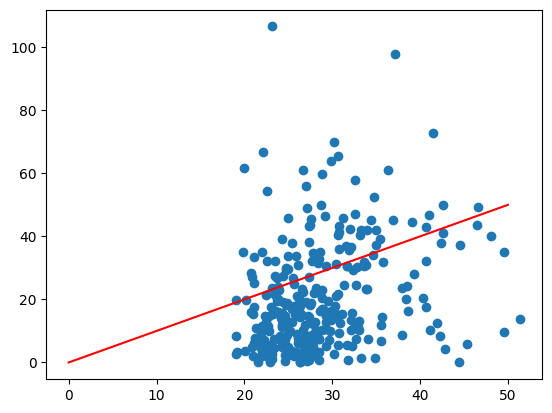

In [197]:
fig, ax = plt.subplots()
ax.scatter(df_spx_daily_expectation_actual[["expected_change_size"]], df_spx_daily_expectation_actual[["actual_change"]].abs())
ax.plot([0, 50], [0, 50], 'k-', color = 'r')

/tmp/ipykernel_9519/3319082594.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 50], [0, 50], 'k-', color = 'r')


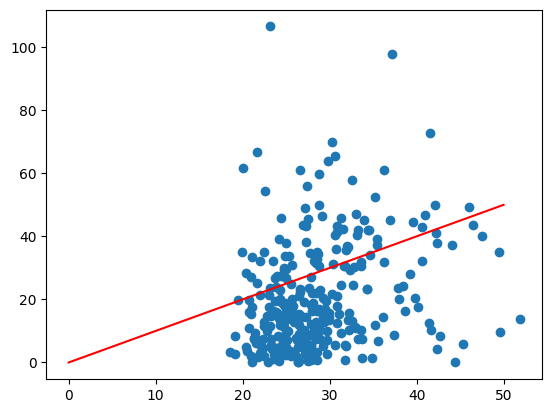

In [68]:
plt.figure()
plt.scatter(df_spx_daily_expectation_actual[["expected_change_size"]], df_spx_daily_expectation_actual[["actual_change"]].abs())
plt.plot([0, 50], [0, 50], 'k-', color = 'r')

In [697]:
df_spx_daily_expectation_actual["regime"] * df_spx_daily_expectation_actual["expected_change_size"]

t
2023-05-02   -24.92
2023-05-03   -49.50
2023-05-04   -37.96
2023-05-05    33.66
2023-05-08    26.48
              ...  
2024-06-26    25.66
2024-06-27    26.32
2024-06-28    30.78
2024-07-01    27.92
2024-07-02    27.32
Length: 293, dtype: float64

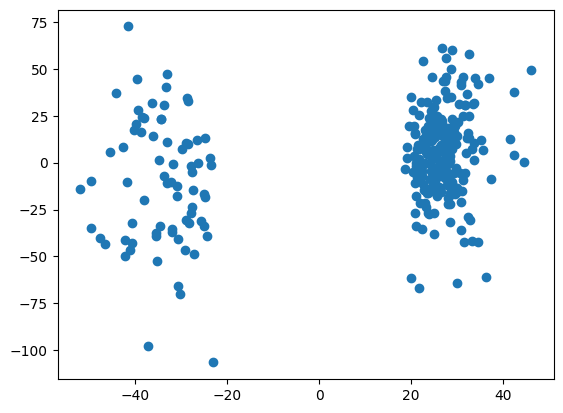

In [700]:
plt.scatter(df_spx_daily_expectation_actual["regime"] * df_spx_daily_expectation_actual["expected_change_size"], df_spx_daily_expectation_actual[["actual_change"]])

In [92]:
df_goog_daily_expectation = get_df_daily_expectation(df_goog_market_open_history)

In [93]:
df_goog_daily_expectation

,c_market_open,regime,expected_move,lower_price,upper_price
t,,,,,
2023-05-02,107.590,-1,0.00300,107.27,107.91
2023-05-03,106.300,-1,0.00600,105.66,106.94
2023-05-04,105.555,-1,0.00465,105.06,106.05
2023-05-05,105.255,1,0.00410,104.82,105.69
2023-05-08,106.650,1,0.00320,106.31,106.99
...,...,...,...,...,...
2024-06-26,184.630,1,0.00235,184.20,185.06
2024-06-27,186.650,1,0.00240,186.20,187.10
2024-06-28,184.450,1,0.00280,183.93,184.97


In [ ]:
df_goog_market_close_history = get_df_market_open_or_close_history_from_intraday_history(df_goog_intraday_history, "close")
df_goog_market_open_close_history = df_goog_market_open_history.join(df_goog_market_close_history, lsuffix="_open", rsuffix="_close")

In [94]:
df_sbux_daily_expectation = get_df_daily_expectation(df_sbux_market_open_history)

## cache intraday options data

In [160]:
df_spx_otm_call_options_spread_history = pd.read_pickle('market_data/df_spx_otm_call_options_spread_history.pkl')
df_spx_otm_put_options_spread_history = pd.read_pickle('market_data/df_spx_otm_put_options_spread_history.pkl')

## logic with options data

In [154]:
df_spx_algo = df_spx_daily_expectation.join(df_spx_otm_call_options_spread_history[["pnl"]].add_suffix("_call")).join(
    df_spx_otm_put_options_spread_history[["pnl"]].add_suffix("_put")
)
df_spx_algo['pnl_c_n_reg'] = np.where(df_spx_algo.regime < 0, df_spx_algo.pnl_call, 0)
df_spx_algo['pnl_p_p_reg'] = np.where(df_spx_algo.regime > 0, df_spx_algo.pnl_put, 0)

In [392]:
df_spx_algo

,c_market_open,regime,expected_move,lower_price,upper_price,pnl_call,pnl_put,pnl_c_n_reg,pnl_p_p_reg
t,,,,,,,,,
2023-05-02,4153.26,-1,0.00300,4140.80,4165.72,0.90,-2.16,0.90,0.00
2023-05-03,4125.70,-1,0.00600,4100.95,4150.45,1.31,-3.62,1.31,0.00
2023-05-04,4081.20,-1,0.00465,4062.22,4100.18,1.10,1.08,1.10,0.00
2023-05-05,4104.23,1,0.00410,4087.40,4121.06,-5.85,1.10,0.00,1.10
2023-05-08,4137.65,1,0.00320,4124.41,4150.89,0.83,0.85,0.00,0.85
...,...,...,...,...,...,...,...,...,...
2024-06-26,5457.73,1,0.00235,5444.90,5470.56,-2.13,0.90,0.00,0.90
2024-06-27,5483.08,1,0.00240,5469.92,5496.24,1.10,0.84,0.00,0.84
2024-06-28,5496.61,1,0.00280,5481.22,5512.00,1.25,-3.76,0.00,-3.76


<AxesSubplot:xlabel='t'>

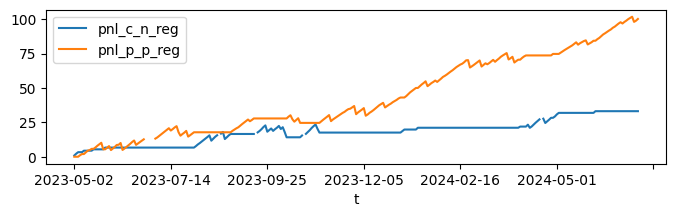

In [390]:
df_spx_algo[["pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

In [388]:
df_spx_algo.groupby("regime")[["pnl_call", "pnl_put"]].sum()

,pnl_call,pnl_put
regime,,
-1,33.14,-74.90
1,-54.36,100.26


In [157]:
df_spx_otm_call_options_spread_history[
    df_spx_algo["regime"] < 0
].sum()

/var/folders/hh/x43xkncs2k7dm7t4vg3lt2cm0000gn/T/ipykernel_96764/2214457600.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spx_otm_call_options_spread_history[


c_market_o_s_call    323.67
c_market_o_l_call    239.52
market_o_spread       84.15
c_market_c_s_call    196.58
c_market_c_l_call    145.57
market_c_spread       51.01
pnl                   33.14
dtype: float64

In [158]:
df_spx_otm_call_options_spread_history.sum()

c_market_o_s_call    1047.16
c_market_o_l_call     732.10
market_o_spread       315.06
c_market_c_s_call    1132.63
c_market_c_l_call     796.35
market_c_spread       336.28
pnl                   -21.22
dtype: float64

In [159]:
df_spx_otm_put_options_spread_history[
    df_spx_algo["regime"] > 0
].sum()

/var/folders/hh/x43xkncs2k7dm7t4vg3lt2cm0000gn/T/ipykernel_96764/465159656.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spx_otm_put_options_spread_history[


c_market_o_s_put    896.91
c_market_o_l_put    668.93
market_o_spread     227.98
c_market_c_s_put    478.88
c_market_c_l_put    351.16
market_c_spread     127.72
pnl                 100.26
dtype: float64

In [160]:
df_spx_otm_put_options_spread_history.sum()

c_market_o_s_put    1306.32
c_market_o_l_put     997.03
market_o_spread      309.29
c_market_c_s_put    1205.80
c_market_c_l_put     921.87
market_c_spread      283.93
pnl                   25.36
dtype: float64

In [394]:
df_goog_algo = df_goog_daily_expectation.join(df_goog_otm_call_options_spread_history[["pnl"]].add_suffix("_call")).join(
    df_goog_otm_put_options_spread_history[["pnl"]].add_suffix("_put")
)
df_goog_algo['pnl_c_n_reg'] = np.where(df_goog_algo.regime < 0, df_goog_algo.pnl_call, 0)
df_goog_algo['pnl_p_p_reg'] = np.where(df_goog_algo.regime > 0, df_goog_algo.pnl_put, 0)

<AxesSubplot:xlabel='t'>

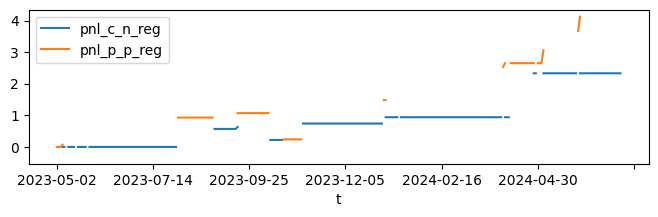

In [395]:
df_goog_algo[["pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

In [259]:
df_goog_algo.groupby("regime")[["pnl_call", "pnl_put"]].sum()

,pnl_call,pnl_put
regime,,
-1,2.33,0.86
1,2.63,3.39


In [396]:
df_sbux_algo = df_sbux_daily_expectation.join(df_sbux_otm_call_options_spread_history[["pnl"]].add_suffix("_call")).join(
    df_sbux_otm_put_options_spread_history[["pnl"]].add_suffix("_put")
)
df_sbux_algo['pnl_c_n_reg'] = np.where(df_sbux_algo.regime < 0, df_sbux_algo.pnl_call, 0)
df_sbux_algo['pnl_p_p_reg'] = np.where(df_sbux_algo.regime > 0, df_sbux_algo.pnl_put, 0)

<AxesSubplot:xlabel='t'>

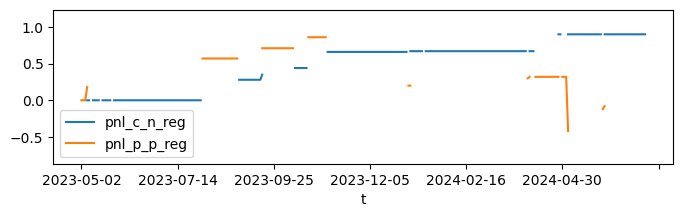

In [397]:
df_sbux_algo[["pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

In [264]:
df_sbux_algo.groupby("regime")[["pnl_call", "pnl_put"]].sum()

,pnl_call,pnl_put
regime,,
-1,0.90,-0.54
1,-0.14,-0.66


## volatility calc

In [125]:
df_goog_atm_vol_history

,atm_call_vol,atm_put_vol
date,,
2023-05-02,0.126841,0.467520
2023-05-03,0.245509,0.277453
2023-05-04,0.206451,0.318878
2023-05-08,0.466368,0.172826
2023-05-09,0.214586,0.505248
...,...,...
2024-06-25,0.500564,0.011800
2024-06-26,0.239714,0.117299
2024-06-27,0.214726,0.145308


In [147]:
df_sbux_atm_vol_history

,atm_call_vol,atm_put_vol
date,,
2023-05-02,0.702781,0.485083
2023-05-03,0.044233,1.038099
2023-05-04,0.327851,0.185386
2023-05-08,0.073481,0.316931
2023-05-09,0.154371,0.234832
...,...,...
2024-06-25,0.068934,0.341830
2024-06-26,0.238235,0.185473
2024-06-27,0.314074,0.132033


In [128]:
df_goog_atm_vol_history["expected_move"] = ((df_goog_atm_vol_history.atm_call_vol + df_goog_atm_vol_history.atm_put_vol) / 2 / np.sqrt(252))

In [149]:
df_sbux_atm_vol_history["expected_move"] = ((df_sbux_atm_vol_history.atm_call_vol + df_sbux_atm_vol_history.atm_put_vol) / 2 / np.sqrt(252))

In [131]:
df_goog_market_close_history = get_df_market_open_or_close_history_from_intraday_history(df_goog_intraday_history, "close")
df_goog_market_open_close_history = df_goog_market_open_history.join(df_goog_market_close_history, lsuffix="_open", rsuffix="_close")
df_goog_market_open_close_history["actual_change"] = df_goog_market_open_close_history.c_close - df_goog_market_open_close_history.c_open

In [140]:
df_goog_daily_expectation_actual = df_goog_daily_expectation.join(df_goog_market_open_close_history["actual_change"])
df_goog_daily_expectation_actual["expected_change_size"] = df_goog_daily_expectation_actual.upper_price - df_goog_daily_expectation_actual.lower_price

In [141]:
df_goog_market_open_close_history

,c_open,c_close,actual_change
t,,,
2023-05-02,107.590,106.04,-1.550
2023-05-03,106.300,106.33,0.030
2023-05-04,105.555,105.28,-0.275
2023-05-05,105.255,105.94,0.685
2023-05-08,106.650,108.99,2.340
...,...,...,...
2024-06-26,184.630,184.95,0.320
2024-06-27,186.650,187.35,0.700
2024-06-28,184.450,183.95,-0.500


In [142]:
df_goog_daily_expectation_actual

,c_market_open,regime,expected_move,lower_price,upper_price,actual_change,expected_change_size
t,,,,,,,
2023-05-02,107.590,-1,0.00300,107.27,107.91,-1.550,0.64
2023-05-03,106.300,-1,0.00600,105.66,106.94,0.030,1.28
2023-05-04,105.555,-1,0.00465,105.06,106.05,-0.275,0.99
2023-05-05,105.255,1,0.00410,104.82,105.69,0.685,0.87
2023-05-08,106.650,1,0.00320,106.31,106.99,2.340,0.68
...,...,...,...,...,...,...,...
2024-06-26,184.630,1,0.00235,184.20,185.06,0.320,0.86
2024-06-27,186.650,1,0.00240,186.20,187.10,0.700,0.90
2024-06-28,184.450,1,0.00280,183.93,184.97,-0.500,1.04


/tmp/ipykernel_9519/4077352078.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 2], [0, 2], 'k-', color = 'r')


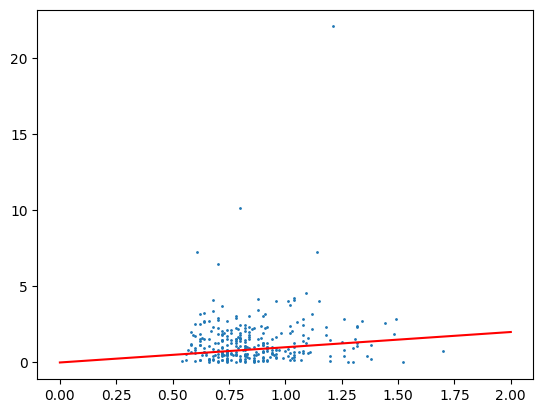

In [154]:
fig, ax = plt.subplots()
ax.scatter(df_goog_daily_expectation_actual[["expected_change_size"]], df_goog_daily_expectation_actual[["actual_change"]].abs(), s=1)
ax.plot([0, 2], [0, 2], 'k-', color = 'r')

In [150]:
df_sbux_market_close_history = get_df_market_open_or_close_history_from_intraday_history(df_sbux_intraday_history, "close")
df_sbux_market_open_close_history = df_sbux_market_open_history.join(df_sbux_market_close_history, lsuffix="_open", rsuffix="_close")
df_sbux_market_open_close_history["actual_change"] = df_sbux_market_open_close_history.c_close - df_sbux_market_open_close_history.c_open

In [151]:
df_sbux_daily_expectation_actual = df_sbux_daily_expectation.join(df_sbux_market_open_close_history["actual_change"])
df_sbux_daily_expectation_actual["expected_change_size"] = df_sbux_daily_expectation_actual.upper_price - df_sbux_daily_expectation_actual.lower_price

/tmp/ipykernel_9519/55571123.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1.5], [0, 1.5], 'k-', color = 'r')


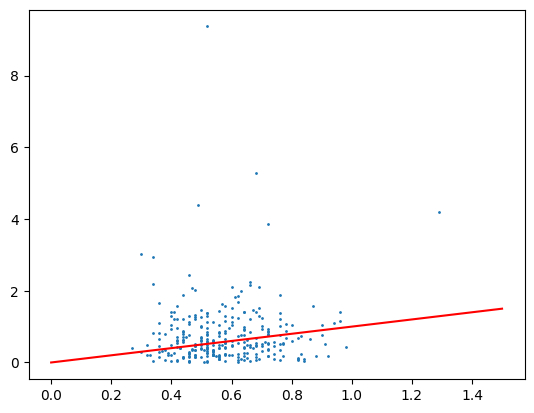

In [155]:
fig, ax = plt.subplots()
ax.scatter(df_sbux_daily_expectation_actual[["expected_change_size"]], df_sbux_daily_expectation_actual[["actual_change"]].abs(), s=1)
ax.plot([0, 1.5], [0, 1.5], 'k-', color = 'r')

## debug

In [328]:
ticker = "GOOG"
date = "2024-06-11"
quote_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(hours = 15, minutes = 55)).value
close_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(hours = 16, minutes = 0)).value

In [347]:
price = df_goog_market_open_history.loc[date].c

In [423]:
calls = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type=call&as_of={date}&limit=1000&apiKey={polygon_api_key}").json()["results"])

In [424]:
calls["days_to_exp"] = (pd.to_datetime(calls["expiration_date"]) - pd.to_datetime(date)).dt.days
#calls = calls[calls["days_to_exp"] >= 5].copy()
nearest_exp_date = calls["expiration_date"].iloc[0]
calls = calls[calls["expiration_date"] == nearest_exp_date].copy()

In [425]:
nearest_exp_date

'2024-06-14'

In [426]:
calls["distance_from_price"] = abs(round(((calls["strike_price"] - price) / price)*100, 2))

In [444]:
calls.head()

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,days_to_exp,distance_from_price
0,OCASPS,call,american,2024-06-14,BATO,100,85.0,O:GOOG240614C00085000,GOOG,3,52.15
1,OCASPS,call,american,2024-06-14,BATO,100,90.0,O:GOOG240614C00090000,GOOG,3,49.34
2,OCASPS,call,american,2024-06-14,BATO,100,95.0,O:GOOG240614C00095000,GOOG,3,46.52
3,OCASPS,call,american,2024-06-14,BATO,100,100.0,O:GOOG240614C00100000,GOOG,3,43.71
4,OCASPS,call,american,2024-06-14,BATO,100,105.0,O:GOOG240614C00105000,GOOG,3,40.89


In [428]:
atm_call = calls.nsmallest(1, "distance_from_price")

In [429]:
atm_call

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,days_to_exp,distance_from_price
27,OCASPS,call,american,2024-06-14,BATO,100,177.5,O:GOOG240614C00177500,GOOG,3,0.08


In [430]:
call_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{atm_call['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=desc&limit=100&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
call_quotes.index = pd.to_datetime(call_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
call_quotes["mid_price"] = round((call_quotes["bid_price"] + call_quotes["ask_price"]) / 2, 2)

In [432]:
time_to_expiration = atm_call.days_to_exp.values[0] / 252

In [433]:
atm_call_vol = call_implied_vol(S=price, K=atm_call["strike_price"].iloc[0], t=time_to_expiration, r=.045, option_price=call_quotes["mid_price"].iloc[0])

In [434]:
atm_call_vol

0.240868986287512

In [ ]:
puts = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type=put&as_of={date}&limit=1000&apiKey={polygon_api_key}").json()["results"])
puts["days_to_exp"] = (pd.to_datetime(puts["expiration_date"]) - pd.to_datetime(date)).dt.days
puts = puts[puts["expiration_date"] == nearest_exp_date].copy()
puts["distance_from_price"] = abs(round(((price - puts["strike_price"]) / puts["strike_price"])*100, 2))
atm_put = puts.nsmallest(1, "distance_from_price")

In [435]:
puts = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type=put&as_of={date}&limit=1000&apiKey={polygon_api_key}").json()["results"])

In [436]:
puts["days_to_exp"] = (pd.to_datetime(puts["expiration_date"]) - pd.to_datetime(date)).dt.days
puts = puts[puts["expiration_date"] == nearest_exp_date].copy()

In [437]:
puts["distance_from_price"] = abs(round(((price - puts["strike_price"]) / puts["strike_price"])*100, 2))

In [438]:
atm_put = puts.nsmallest(1, "distance_from_price")

In [439]:
atm_put

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,days_to_exp,distance_from_price
27,OPASPS,put,american,2024-06-14,BATO,100,177.5,O:GOOG240614P00177500,GOOG,3,0.08


In [440]:
put_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{atm_put['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=desc&limit=100&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
put_quotes.index = pd.to_datetime(put_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
put_quotes["mid_price"] = round((put_quotes["bid_price"] + put_quotes["ask_price"]) / 2, 2)

In [441]:
atm_put_vol = put_implied_vol(S=price, K=atm_put["strike_price"].iloc[0], t=time_to_expiration, r=.045, option_price=put_quotes["mid_price"].iloc[0])

In [442]:
atm_put_vol

0.1921287338318709

In [443]:
atm_vol = round(((atm_call_vol + atm_put_vol) / 2)*100, 2)
expected_move = (round((atm_vol / np.sqrt(252)), 2))

In [ ]:

end_time = datetime.now()
seconds_to_complete = (end_time - start_time).total_seconds()
times.append(seconds_to_complete)
iteration = round((np.where(trading_dates==date)[0][0]/len(trading_dates))*100,2)
iterations_remaining = len(trading_dates) - np.where(trading_dates==date)[0][0]
average_time_to_complete = np.mean(times)
estimated_completion_time = (datetime.now() + timedelta(seconds = int(average_time_to_complete*iterations_remaining)))
time_remaining = estimated_completion_time - datetime.now()
print(f"{iteration}% complete, {time_remaining} left, ETA: {estimated_completion_time}")
